In [1]:
%load_ext autoreload
%autoreload 2

from cobolt.utils import SingleData, MultiomicDataset
from cobolt.model import Cobolt
import os
import gc
import numpy as np
import pandas as pd
import scipy.sparse as sps
import scanpy as sc
import scipy.io as sio

from os.path import join
import matplotlib.pyplot as plt

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/tqdm-4.65.0-py3.8.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' 

In [2]:
# Path to the data directory
data_dir = "/home/sda1/yanxh/data/DOGMA"

## Read Data

In [3]:
print('Reading `mtx` files...')
rna_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'RNA/rna_mat_count.mtx')).T)
adt_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'ADT/adt_mat_count.mtx')).T)
atac_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'ATAC/atac_mat_count.mtx')).T)

rna_names = pd.read_csv(join(data_dir, 'RNA/hvg_names.csv'))['VariableFeatures(data_ref)'].to_numpy()
adt_names = pd.read_csv(join(data_dir, 'ADT/adt_names.csv'))['VariableFeatures(data_ref)'].to_numpy()
atac_names = pd.read_csv(join(data_dir, 'ATAC/hvp_names.csv'))['VariableFeatures(data_ref)'].to_numpy()

cell_names = pd.read_csv(join(data_dir, 'cell_names.csv'))['x'].to_numpy()
meta_data = pd.read_csv(join(data_dir, 'metadata.csv'), index_col=0)
meta_data = meta_data[['stim', 'predicted.celltype.l1', 'predicted.celltype.l2']].copy()

rna_count_mat.shape, adt_count_mat.shape, atac_count_mat.shape

Reading `mtx` files...


((13763, 2000), (13763, 210), (13763, 50285))

In [5]:
train_idx = np.where((meta_data.stim=='Control').to_numpy())[0]
test_idx  = np.where((meta_data.stim=='Stim').to_numpy())[0]

train_idx.size, test_idx.size

(7624, 6139)

In [6]:
mult_rna_count = rna_count_mat[train_idx].astype(np.float32)
mult_adt_count = adt_count_mat[train_idx].astype(np.float32)
mult_atac_count = atac_count_mat[train_idx].astype(np.float32)
mult_rna_count = sps.csr_matrix(mult_rna_count)   # this fucking thing must be in csr format, otherwise, training will be fucking very 
mult_adt_count = sps.csr_matrix(mult_adt_count)   # slowly, fuck, fuck, fuck
mult_atac_count = sps.csr_matrix(mult_atac_count) 

mult_barcode = cell_names[train_idx]

rna_feature = rna_names
adt_feature = adt_names
atac_feature = atac_names

Alternatively, a `SingleData` object can also be constructed using a processed
scipy sparse matrix of counts and string arrays of feature and barcode names.
We show an example below for reading the mRNA data from sparse matrix.

In [7]:
mult_rna = SingleData("GeneExpr", "Multiome", rna_feature, mult_rna_count, mult_barcode)
mult_adt = SingleData("ADT", "Multiome", adt_feature, mult_adt_count, mult_barcode)
mult_atac = SingleData("ATAC", "Multiome", atac_feature, mult_atac_count, mult_barcode)

In [8]:
single_rna_count = rna_count_mat[test_idx].astype(np.float32)
single_adt_count = adt_count_mat[test_idx].astype(np.float32)
single_atac_count = atac_count_mat[test_idx].astype(np.float32)
single_rna_count = sps.csr_matrix(single_rna_count)
single_adt_count = sps.csr_matrix(single_adt_count)
single_atac_count = sps.csr_matrix(single_atac_count)
single_rna_barcode = [_+'_rna' for _ in cell_names[test_idx]]
single_adt_barcode = [_+'_adt' for _ in cell_names[test_idx]]
single_atac_barcode = [_+'_atac' for _ in cell_names[test_idx]]

rna_feature = rna_names
adt_feature = adt_names
atac_feature = atac_names

In [9]:
single_rna_barcode[:5]

['AAACAGCCAACCTGGT-2_rna',
 'AAACAGCCACAATACT-2_rna',
 'AAACAGCCACAGACTC-2_rna',
 'AAACAGCCAGGTTTGC-2_rna',
 'AAACAGCCATAAGGAC-2_rna']

In [10]:
single_rna = SingleData("GeneExpr", "Single-GEX", rna_feature, single_rna_count, single_rna_barcode)
single_adt = SingleData("ADT", "Single-ADT", adt_feature, single_adt_count, single_adt_barcode)
single_atac = SingleData("ATAC", "Single-ATAC", atac_feature, single_atac_count, single_atac_barcode)

Merge the above three datasets. Cells with the identical barcode names and
dataset names are recognized as joint cells. Cobolt focus on common features
shared across datasets. Genes are subset to those detected by both SNARE-seq
and scRNA-seq. We also performed preprocessing that mapped the SNARE-seq
chromatin accessibility counts to peaks called on the scATAC-seq dataset, such
that they share the same feature set. A batch variable is
automatically added when merging datasets. Different datasets are treated as
different batches.

In [11]:
multi_dt = MultiomicDataset.from_singledata(
    single_rna, single_adt, single_atac, mult_adt, mult_rna, mult_atac)
print(multi_dt)

A MultiomicDataset object with 3 omics:
- GeneExpr: 2000 features, 13763 cells, 2 batches.
- ADT: 210 features, 13763 cells, 2 batches.
- ATAC: 50285 features, 13763 cells, 2 batches.
Joint cells:
- ADT, ATAC: 7624 cells.
- GeneExpr, ATAC: 7624 cells.
- GeneExpr, ADT: 7624 cells.
- GeneExpr, ADT, ATAC: 7624 cells.


## Training

We now train the Cobolt model with the number of latent variables set to 10. We
use a small iteration in this vignette for illustration purpose. The default
number of iteration is set to 100.

In [13]:
model = Cobolt(dataset=multi_dt, lr=0.001, n_latent=10, batch_size=128) 
model.train(num_epochs=100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [37:26<00:00, 22.47s/it]


Calculate the corrected latent variables.

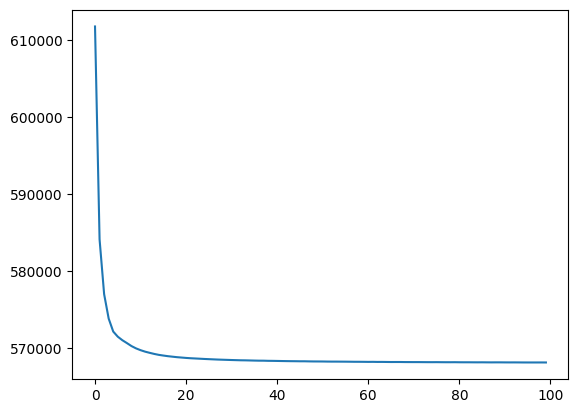

In [14]:
plt.plot(model.history['loss'])

In [15]:
model.calc_all_latent()

latent = model.get_all_latent()

# latent_raw = model.get_all_latent(correction=False)

### Evaluation

In [12]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

In [13]:
if False:
    latent_barcode = np.array([_.split('~')[1] for _ in latent[1]])
    df_latent = pd.DataFrame(latent[0], index=latent_barcode)
    df_latent.to_csv('./outputs/dogma.csv')

else:
    df_latent = pd.read_csv('./outputs/dogma.csv', index_col=0)

In [14]:
gex_test = sc.AnnData(single_rna_count)
gex_test.obs_names = single_rna_barcode
adt_test = sc.AnnData(single_adt_count)
adt_test.obs_names = single_adt_barcode
atac_test = sc.AnnData(single_atac_count)
atac_test.obs_names = single_atac_barcode

ad_mult = sc.AnnData(mult_rna_count)
ad_mult.obs_names = mult_barcode

In [15]:
ad_mult.obsm['X_emb'] = df_latent.loc[ad_mult.obs_names, :].values
gex_test.obsm['X_emb'] = df_latent.loc[gex_test.obs_names, :].values
adt_test.obsm['X_emb'] = df_latent.loc[adt_test.obs_names, :].values
atac_test.obsm['X_emb'] = df_latent.loc[atac_test.obs_names, :].values

In [16]:
gex_test.obs_names[0].rsplit('_', 1)

['AAACAGCCAACCTGGT-2', 'rna']

In [17]:
ad_mult.obs[['batch', 'cell_type']] = meta_data.loc[ad_mult.obs_names, ['stim', 'predicted.celltype.l1']].to_numpy()
gex_test.obs[['batch', 'cell_type']] = meta_data.loc[
    [_.rsplit('_', 1)[0] for _ in gex_test.obs_names], 
    ['stim', 'predicted.celltype.l1']
].to_numpy()
adt_test.obs[['batch', 'cell_type']] = meta_data.loc[
    [_.rsplit('_', 1)[0] for _ in adt_test.obs_names], 
    ['stim', 'predicted.celltype.l1']
].to_numpy()
atac_test.obs[['batch', 'cell_type']] = meta_data.loc[
    [_.rsplit('_', 1)[0] for _ in atac_test.obs_names], 
    ['stim', 'predicted.celltype.l1']
].to_numpy()

ad_mult.obs['mod'] = 'multiome'
gex_test.obs['mod'] = 'gex'
adt_test.obs['mod'] = 'adt'
atac_test.obs['mod'] = 'atac'
ad_mult.uns['mod'] = 'multiome'
gex_test.uns['mod'] = 'gex'
adt_test.uns['mod'] = 'adt'
atac_test.uns['mod'] = 'atac'

ad_mult.obs['mod-batch'] = ad_mult.obs.batch.apply(lambda x: 'multiome'+'-'+x).to_numpy()
gex_test.obs['mod-batch'] = gex_test.obs.batch.apply(lambda x: 'gex'+'-'+x).to_numpy()
adt_test.obs['mod-batch'] = adt_test.obs.batch.apply(lambda x: 'adt'+'-'+x).to_numpy()
atac_test.obs['mod-batch'] = atac_test.obs.batch.apply(lambda x: 'atac'+'-'+x).to_numpy()

In [19]:
import sys
sys.path.insert(0, '/home/yanxh/gitrepo/multi-omics-matching/ACE/reproduce/evaluation')

from evaluation import eval_mosaic, eval_specific_mod, eval_bridge, print_results, eval_asw, eval_lisi, eval_clustering
from evaluation import eval_bridge_above2

### (1) Mosaic eval

### 1.1 without harmony

In [23]:
ad_mosaic = sc.concat([ad_mult, gex_test, adt_test, atac_test])

r = eval_mosaic(ad_mosaic, label_key='cell_type', lisi_keys=['mod-batch', 'mod'], use_rep='X_emb',
               use_lisi=True, use_gc=False, use_nmi=False)

mod-batch_LISI=0.58015
mod_LISI=0.58015


In [24]:
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb',
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.523706320911842, 0.6156603312410986)

In [25]:
r = eval_bridge_above2(
    [gex_test, adt_test, atac_test],
    label_key='cell_type',
    batch_key='batch',
    mod_key='mod',
    use_rep='X_emb',
    use_acc=False
)

FOSCTTM: gex-adt=0.08936
FOSCTTM: gex-atac=0.05776
FOSCTTM: adt-atac=0.09742
FOSCTTM=0.08151
Matching score: gex-adt=0.00573
Matching score: gex-atac=0.02127
Matching score: adt-atac=0.00658
Match_score=0.01119


### 1.2 with harmony

In [23]:
from preprocessing import harmony

In [27]:
ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
ad_mosaic_df['batch'] = ad_mosaic.obs['mod-batch'].to_numpy()
ad_mosaic.obsm['X_emb_harmony'] = harmony([ad_mosaic_df])[0]

r = eval_mosaic(ad_mosaic, label_key='cell_type', lisi_keys=['mod-batch'], use_rep='X_emb_harmony',
               use_lisi=True, use_gc=False, use_nmi=False)

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).
mod-batch_LISI=0.71909


In [28]:
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb_harmony',
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.47951919596362685, 0.3514056028061399)

In [29]:
gex_test.obsm['X_emb_harmony'] = ad_mosaic.obsm['X_emb_harmony'][ad_mult.shape[0]:(ad_mult.shape[0] + gex_test.shape[0])]
adt_test.obsm['X_emb_harmony'] = ad_mosaic.obsm['X_emb_harmony'][
    (ad_mult.shape[0] + gex_test.shape[0]):(ad_mult.shape[0] + gex_test.shape[0] + adt_test.shape[0])]
atac_test.obsm['X_emb_harmony'] = ad_mosaic.obsm['X_emb_harmony'][-atac_test.shape[0]:]

r = eval_bridge_above2(
    [gex_test, adt_test, atac_test],
    label_key='cell_type',
    batch_key='batch',
    mod_key='mod',
    use_rep='X_emb_harmony',
    use_acc=False
)

FOSCTTM: gex-adt=0.09022
FOSCTTM: gex-atac=0.05628
FOSCTTM: adt-atac=0.09652
FOSCTTM=0.08101
Matching score: gex-adt=0.00725
Matching score: gex-atac=0.02107
Matching score: adt-atac=0.00710
Match_score=0.01181


## Clustering and Visualization

In [20]:
umap_save_dir = '/home/sda1/yanxh/outputs/umap_plots'

In [21]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)

In [24]:
# ad_mosaic = sc.concat([ad_mult, gex_test, adt_test, atac_test])
# ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb', add_key='X_umap_1')

ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
ad_mosaic_df['batch'] = ad_mosaic.obs['mod-batch'].to_numpy()
ad_mosaic.obsm['X_emb_harmony'] = harmony([ad_mosaic_df])[0]
ad_mosaic = get_umap(ad_mosaic, use_rep='X_emb_harmony', add_key='X_harmony_umap')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


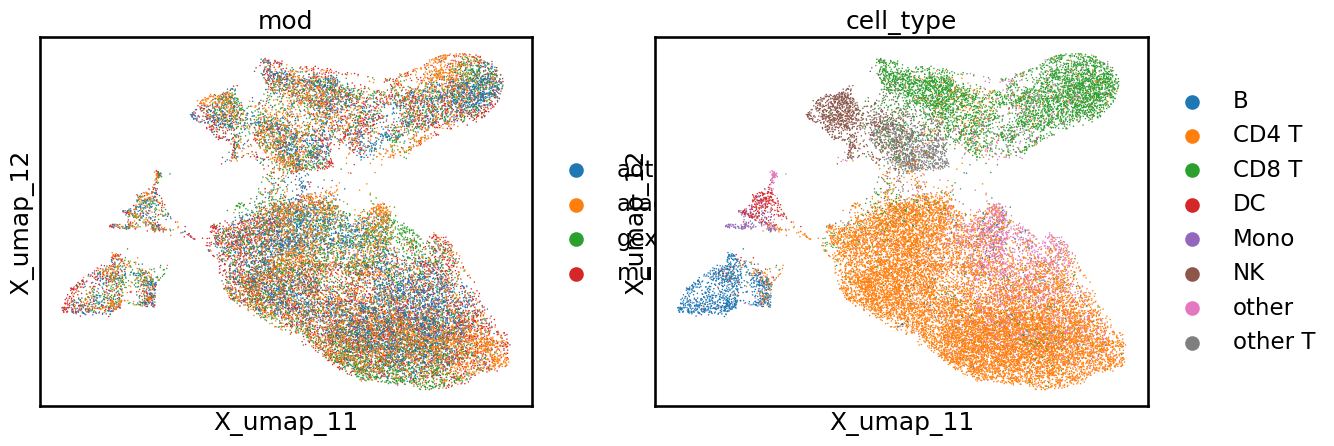

In [25]:
sc.pl.embedding(ad_mosaic, basis='X_umap_1', color=['mod', 'cell_type'], legend_loc='right margin')

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages

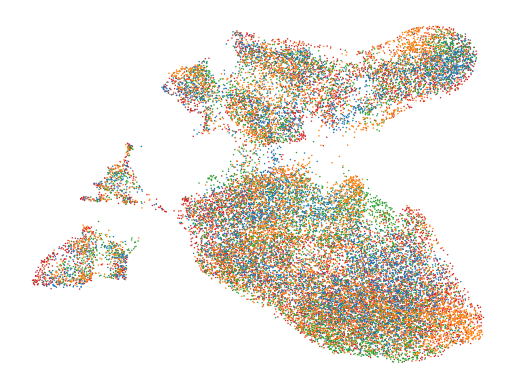

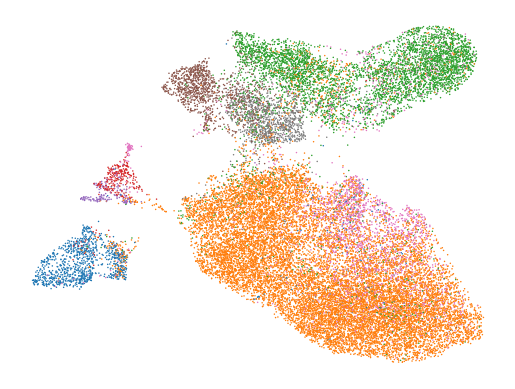

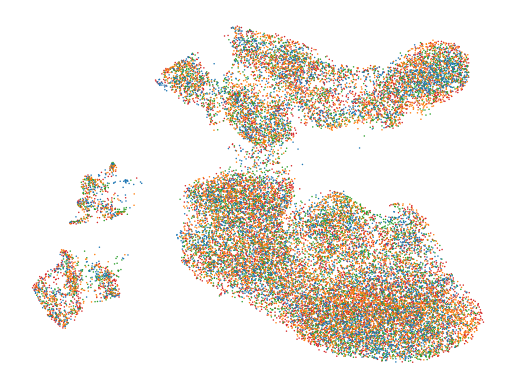

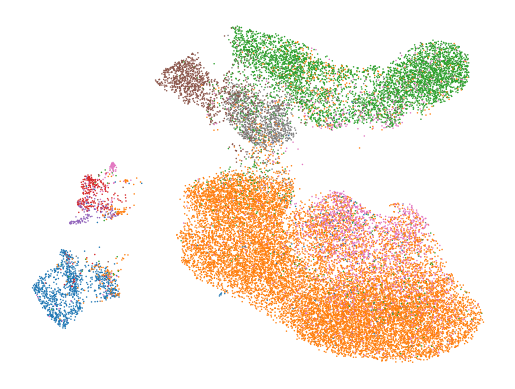

In [26]:
save_umap(ad_mosaic, 'X_umap_1', ['mod', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec2/umap', 
          prefix_name='cobolt_case2_dogma')

save_umap(ad_mosaic, 'X_harmony_umap', ['mod', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec2/umap', 
          prefix_name='cobolt-harmony_case2_dogma')

In [27]:
np.save(join(umap_save_dir, 'cobolt_case2_dogma_umap.npy'), ad_mosaic.obsm['X_umap_1'])
np.save(join(umap_save_dir, 'cobolt-harmony_case2_dogma_umap.npy'), ad_mosaic.obsm['X_harmony_umap'])